In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set project folder directory
DATA_DIR = '/content/drive/MyDrive/W281 Project/data'

In [3]:
# load some lib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib
import cv2 as cv


# read in metadata
df_meta = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_Metadata.csv", index_col = 0)
df_meta

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [4]:
# read in summary of data set
df_data_summary = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_dataset_Summary.csv", index_col = 0)
df_data_summary['Label_2_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal',
                                              np.where(
                                                  (df_data_summary['Label_2_Virus_category'] != df_data_summary['Label_2_Virus_category']) & 
                                                  ~(df_data_summary['Label_1_Virus_category'] != df_data_summary['Label_1_Virus_category']),
                                                  df_data_summary['Label_1_Virus_category'],
                                                  df_data_summary['Label_2_Virus_category']
                                              ))

df_data_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,Normal,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,Virus,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,bacteria,2772
6,Pnemonia,bacteria,Streptococcus,5


Normal
Pnemonia


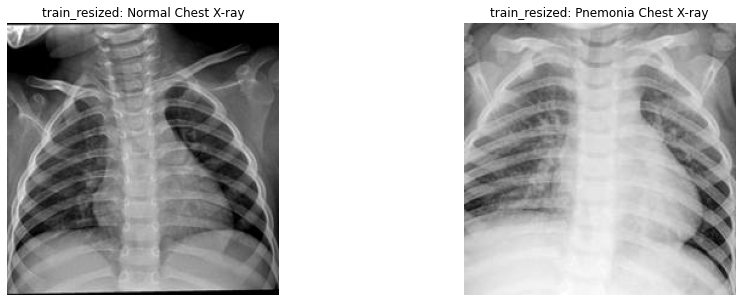

In [ ]:
# get an image
# load image data
def grab_one_and_plot(df, col_category, data_set = 'train'):
  """
    For data visualization, grab each image from the specified column directory
    Show the image
  """
  # copy the meta; avoid mutation
  df_copy = df.copy()


  # instantitae canvas for plotting
  plt.figure(figsize=(15,5))

  for i, cat in enumerate(df_copy[col_category].unique()):

      print(cat)

      # locate the image and build path to the image
      img_meta = df_copy[df_copy[col_category] == cat].iloc[103]
      train_test = data_set
      path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"


      # grab the image path and plot
      img = Image.open(path)
      plt.subplot(1, len(df_copy[col_category].unique()), i+1)
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      plt.title(f"{train_test}: {cat} Chest X-ray")
      
      
  plt.show()

grab_one_and_plot(df_meta, "Label", "train_resized")

In [ ]:
# Testing on images with white cloud
df_copy = df_meta.copy()
train_test = 'train_resized'

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[103]
path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# grab the image 
img = cv.imread(path)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)

# cv.imwrite('sift_keypoints.jpg',img)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite(f'{DATA_DIR}/processed/sift_keypoints_cloud.jpg',img)

True

In [ ]:
# Testing on images of normal patient
df_copy = df_meta.copy()
train_test = 'train_resized'

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Normal'].iloc[103]
path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# grab the image 
img = cv.imread(path)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
# cv.imwrite('sift_keypoints.jpg',img)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite(f'{DATA_DIR}/processed/sift_keypoints_normal_1.jpg',img)

True

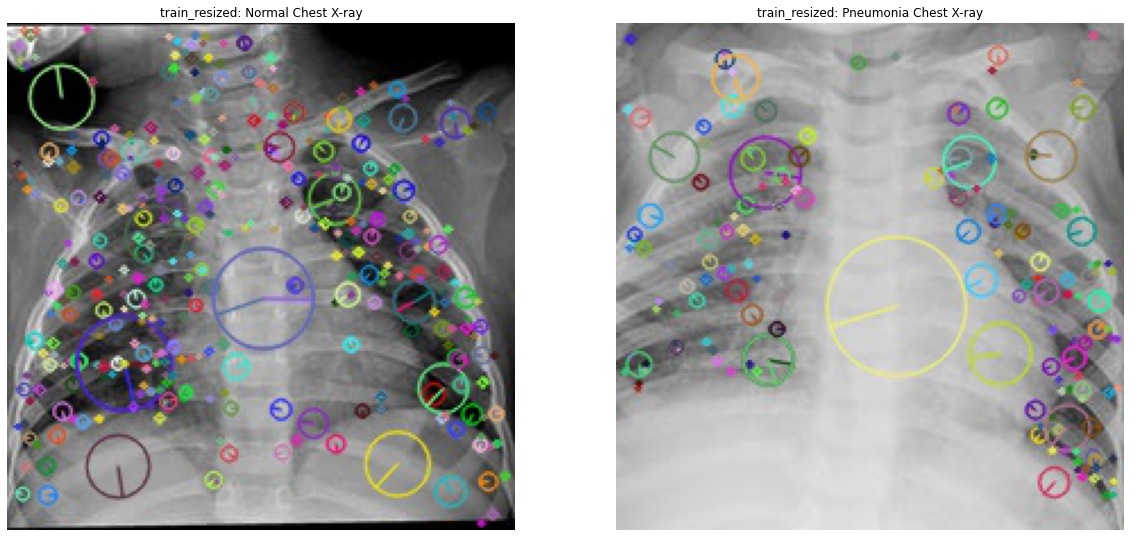

In [ ]:
# grab the image path and plot
path_1 = f"{DATA_DIR}/processed/sift_keypoints_normal_1.jpg"
path_2 = f"{DATA_DIR}/processed/sift_keypoints_cloud.jpg"

img_1 = Image.open(path_1)
img_2 = Image.open(path_2)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_1, cmap='gray')
plt.axis('off')
plt.title(f"{train_test}: Normal Chest X-ray")

plt.subplot(1,2,2)
plt.imshow(img_2, cmap='gray')
plt.axis('off')
plt.title(f"{train_test}: Pneumonia Chest X-ray")
plt.show()

In [ ]:
# Testing on images with no visible white cloud
df_copy = df_meta.copy()
train_test = 'train_resized'

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[153]
path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# grab the image 
img = cv.imread(path)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
# cv.imwrite('sift_keypoints.jpg',img)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite(f'{DATA_DIR}/processed/sift_keypoints_no_cloud.jpg',img)

True

In [ ]:
# Testing on images of normal patient
df_copy = df_meta.copy()
train_test = 'train_resized'

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Normal'].iloc[153]
path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# grab the image 
img = cv.imread(path)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
# cv.imwrite('sift_keypoints.jpg',img)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite(f'{DATA_DIR}/processed/sift_keypoints_normal_2.jpg',img)

True

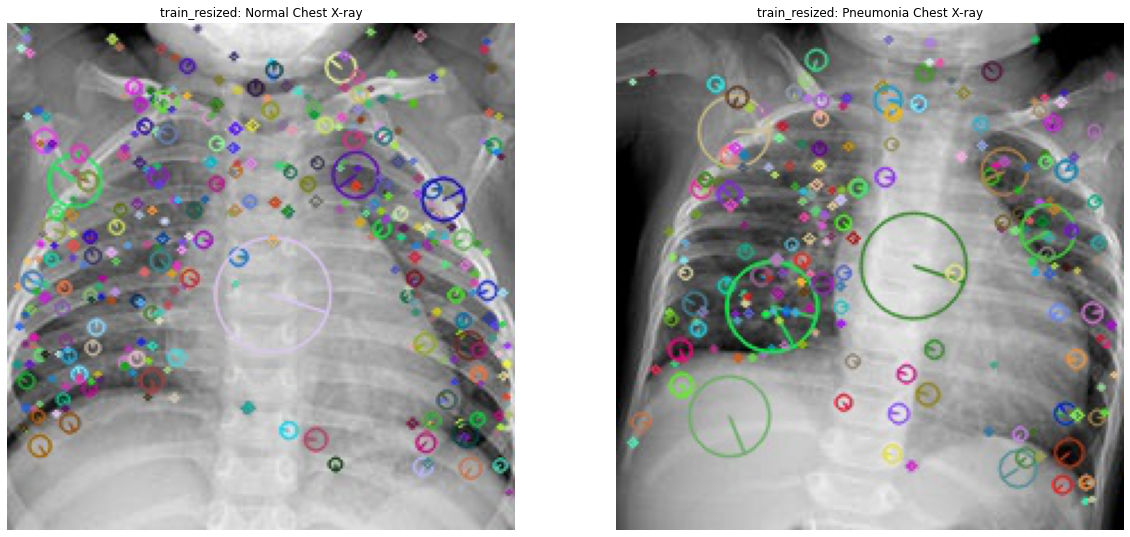

In [ ]:
# grab the image path and plot
path_1 = f'{DATA_DIR}/processed/sift_keypoints_normal_2.jpg'
path_2 = f'{DATA_DIR}/processed/sift_keypoints_no_cloud.jpg'

img_1 = Image.open(path_1)
img_2 = Image.open(path_2)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_1, cmap='gray')
plt.axis('off')
plt.title(f"{train_test}: Normal Chest X-ray")

plt.subplot(1,2,2)
plt.imshow(img_2, cmap='gray')
plt.axis('off')
plt.title(f"{train_test}: Pneumonia Chest X-ray")
plt.show()

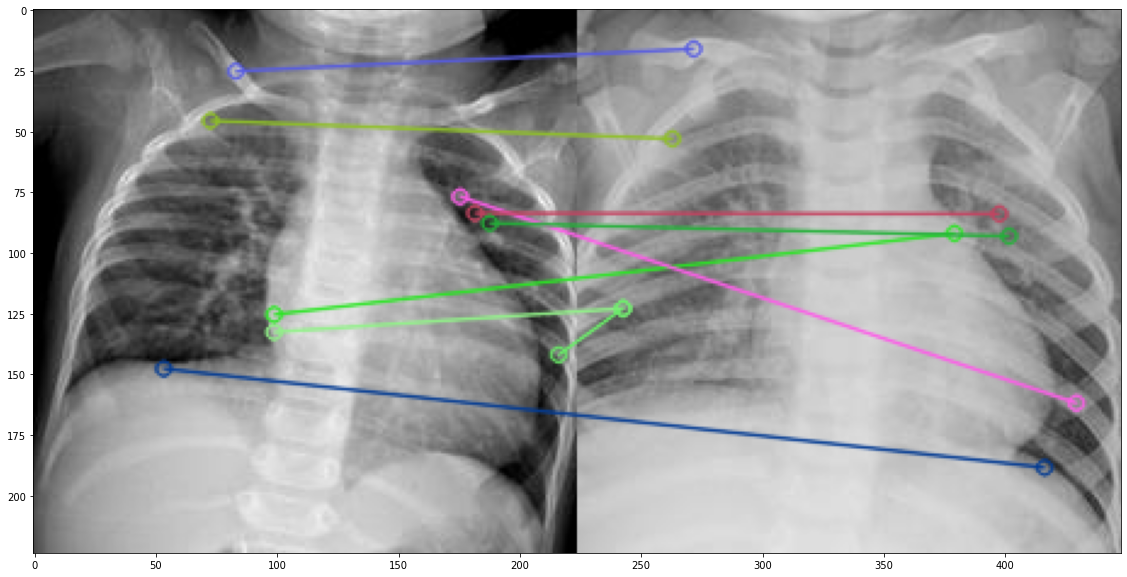

(<matplotlib.image.AxesImage at 0x7f50a8942520>, None)

In [ ]:
# matching experiment on cloudly vs non-cloudy
# Testing on images with no visible white cloud
df_copy = df_meta.copy()
train_test = 'train_resized'

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[153]
no_cloud_path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[103]
cloud_path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# grab the image 
img_no_cloud = cv.imread(no_cloud_path, cv.COLOR_BGR2GRAY)
img_cloud = cv.imread(cloud_path, cv.COLOR_BGR2GRAY)

# initiate SIFT features detector
sift = cv.SIFT_create()

# locate keypoints and descriptor
# find the keypoints and descriptors with ORB
kp1, des1 = sift.detectAndCompute(img_no_cloud,None)
kp2, des2 = sift.detectAndCompute(img_cloud,None)

# create BFMatcher object
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# # Match descriptors.
# matches = bf.knnMatch(des1,des2,k=2)


# Sort them in the order of their distance.
# Apply ratio test
good = []
for m, n in matches:
    #print(m.distance, n.distance)
    if m.distance < 0.80*n.distance:
        good.append([m])


# Draw first 10 matches.
plt.figure(figsize=(20,10))


img3 = cv.drawMatchesKnn(img_no_cloud,kp1,img_cloud,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

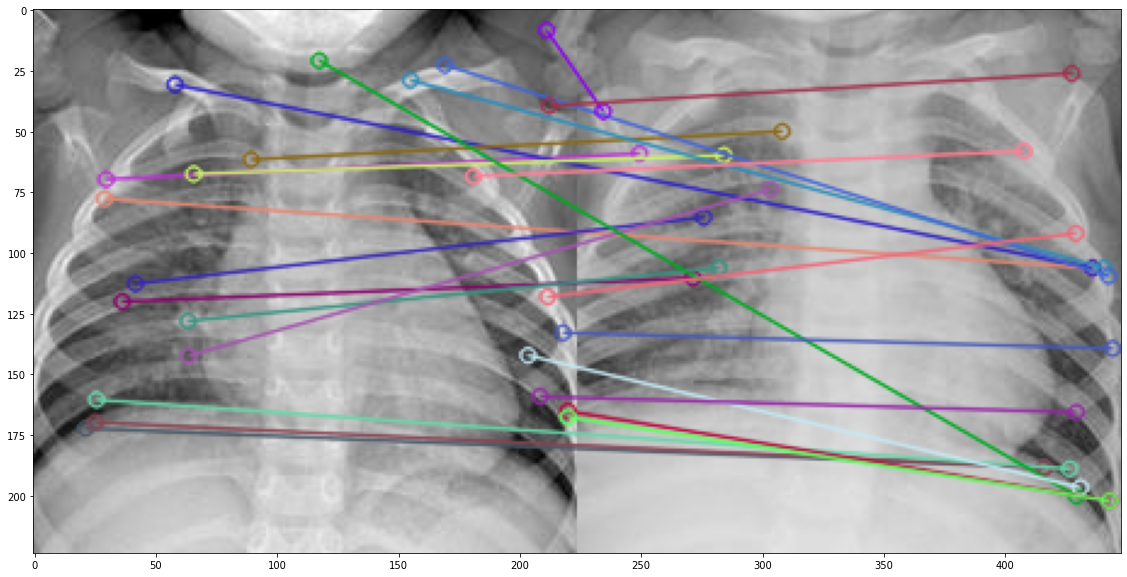

(<matplotlib.image.AxesImage at 0x7f50a8864640>, None)

In [ ]:
# matching experiment on cloudly vs non-cloudy
# Testing on images with no visible white cloud
df_copy = df_meta.copy()
train_test = 'train_resized'

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Normal'].iloc[153]
no_cloud_path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# locate the image and build path to the image
img_meta = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[103]
cloud_path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"

# grab the image 
img_no_cloud = cv.imread(no_cloud_path, cv.COLOR_BGR2GRAY)
img_cloud = cv.imread(cloud_path, cv.COLOR_BGR2GRAY)

# initiate SIFT features detector
sift = cv.SIFT_create()

# locate keypoints and descriptor
# find the keypoints and descriptors with ORB
kp1, des1 = sift.detectAndCompute(img_no_cloud,None)
kp2, des2 = sift.detectAndCompute(img_cloud,None)

# create BFMatcher object
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# # Match descriptors.
# matches = bf.knnMatch(des1,des2,k=2)


# Sort them in the order of their distance.
# Apply ratio test
good = []
for m,n in matches:
    #print(m.distance, n.distance)
    if m.distance < 0.75*n.distance:
        good.append([m])


# Draw first 10 matches.
plt.figure(figsize=(20,10))


img3 = cv.drawMatchesKnn(img_no_cloud,kp1,img_cloud,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

# SIFT Multi Images Experiment
Grab a set of normal and a set of pneumonia patients. Obtain at least a 75% matches

In [5]:
from pandas._libs.tslibs import normalize_i8_timestamps
# match experiments
# matching experiment on cloudly vs non-cloudy
# Testing on images with no visible white cloud
df_copy = df_meta.copy()
train_test = 'train_resized'


mmr_normal_vs_pneumomia = []

for i in range(0, 1000):
  img_idx = np.random.randint(0,500)
  normal_meta = df_copy[df_copy['Label'] == 'Normal'].iloc[img_idx]
  pneumonia_meta = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[img_idx]

  normal = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{normal_meta['X_ray_image_name']}"
  pneumonia = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{pneumonia_meta['X_ray_image_name']}"


  # grab the image 
  img_normal = cv.imread(normal, cv.COLOR_BGR2GRAY)
  img_pneumonia = cv.imread(pneumonia, cv.COLOR_BGR2GRAY)

  # initiate SIFT features detector
  sift = cv.SIFT_create()

  # locate keypoints and descriptor
  # find the keypoints and descriptors with ORB
  kp1, des1 = sift.detectAndCompute(img_normal,None)
  kp2, des2 = sift.detectAndCompute(img_pneumonia,None)

  try:
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    matches = matches[:100]

    # get best matches by Lowe's distance ratio (best matches between two points)
    # Sort them in the order of their distance.
    # Apply ratio test
    good = []
    for m,n in matches:
        #print(m.distance, n.distance)
        if m.distance < 0.75*n.distance:
            good.append([m])

    mmr_normal_vs_pneumomia.append(len(good)/len(matches))

  except Exception as e:
    print(e)




OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

not enough values to unpack (expected 2, got 1)
OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

not enough values to unpack (expected 2, got 1)
OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'



In [6]:
# match experiments
# matching experiment on cloudly vs non-cloudy
# Testing on images with no visible white cloud
df_copy = df_meta.copy()
train_test = 'train_resized'


mmr_pneumomia_vs_pneumomia = []

for i in range(0, 1000):
  img_idx = np.random.randint(0,500)
  pneumonia_meta_1 = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[img_idx]
  pneumonia_meta_2 = df_copy[df_copy['Label'] == 'Pnemonia'].iloc[img_idx+np.random.randint(1,5)]

  pneumonia_1 = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{pneumonia_meta_1['X_ray_image_name']}"
  pneumonia_2 = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{pneumonia_meta_2['X_ray_image_name']}"

  # grab the image 
  img_pneumonia_1 = cv.imread(pneumonia_1, cv.COLOR_BGR2GRAY)
  img_pneumonia_2 = cv.imread(pneumonia_2, cv.COLOR_BGR2GRAY)

  # initiate SIFT features detector
  sift = cv.SIFT_create()

  # locate keypoints and descriptor
  # find the keypoints and descriptors with ORB
  kp1, des1 = sift.detectAndCompute(img_pneumonia_1,None)
  kp2, des2 = sift.detectAndCompute(img_pneumonia_2,None)

  try:
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    matches = matches[:100]
    # get best matches by Lowe's distance ratio (best matches between two points)
    # Sort them in the order of their distance.
    # Apply ratio test
    good = []
    for m,n in matches:
        #print(m.distance, n.distance)
        if m.distance < 0.75*n.distance:
            good.append([m])

    mmr_pneumomia_vs_pneumomia.append(len(good)/len(matches))

  except Exception as e:
    print(e)

OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

division by zero
division by zero
OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Assertion failed) _queryDescriptors.type() == trainDescType in function 'knnMatchImpl'

not enough values to unpack (expected 2, got 1)
OpenCV(4.7.0) /io/opencv/modules/features2d/src/matchers.cpp:761: error: (-215:Asse

<Figure size 640x480 with 0 Axes>

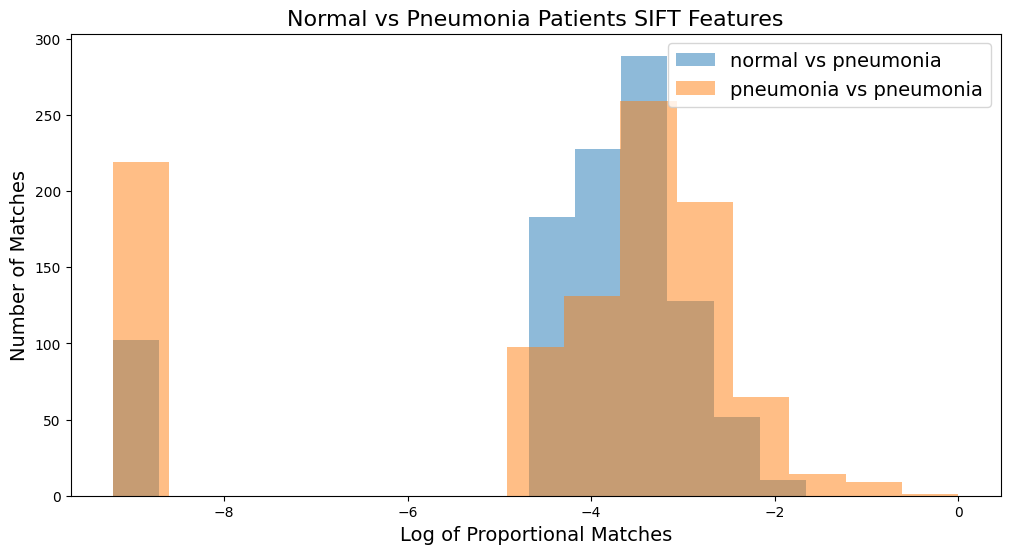

In [10]:
plt.clf()
plt.figure(figsize=(12,6))
plt.hist(np.log([0.0001 + n for n in mmr_normal_vs_pneumomia]), alpha = 0.5, bins = 15, label = "normal vs pneumonia")
plt.hist(np.log([0.0001 + n for n in mmr_pneumomia_vs_pneumomia]), alpha=0.5, bins = 15, label = "pneumonia vs pneumonia")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Log of Proportional Matches", fontsize=14)
plt.ylabel("Number of Matches", fontsize=14)
plt.title("Normal vs Pneumonia Patients SIFT Features", fontsize=16)
plt.show()

In [8]:
# performing 2 samples hypothesis test
# Import library
import scipy.stats as stats

normal_vs_pneumonia_group = np.log([0.0001 + n for n in mmr_normal_vs_pneumomia])
pneumomia_vs_pneumomia_group = np.log([0.0001 + n for n in mmr_pneumomia_vs_pneumomia])

# Print the variance of both data groups
print(np.mean(normal_vs_pneumonia_group), np.mean(pneumomia_vs_pneumomia_group))


# Perform the two sample t-test with equal variances
stats.ttest_ind(a=normal_vs_pneumonia_group, b=pneumomia_vs_pneumomia_group, equal_var=True)

# The resulted p-value is < 0.05, there is sufficient evidence to reject the Null hypothesis.
# This test suggests that SIFT features can distinguish the average amount of matches between pneunomia infected patients and normal patients 

3.262281355126794 6.445340543059207


Ttest_indResult(statistic=4.217448405861248, pvalue=2.5822658914376282e-05)